In [1]:
!pip install gensim nltk

In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

## Word2vec from Scratch with Numpy

### Word Embedding
-> Method to represent a word numerically.
One straight-forward method is One-HotEncoding Method.

Word2vec is a `neural network structure` to generate word embedding by training the model on a supervised classification problem. 

### Word2Vec (Skipgram)
In `Mikolov et al.,2013`, **two model** architectures were presented, Continuous Bag-of-Words model and Skip-gram model.

### Model Overview
The following shows the original diagram presented in the paper by Mikolov et al.,2013.
![Skip-gram](https://miro.medium.com/v2/resize:fit:640/format:webp/1*SAo8-mAupp44NEsWCgCGAg.png)
Another graph with bit more details
![More-detailed-graph](https://miro.medium.com/v2/resize:fit:828/format:webp/1*Kc8WNpwN31N5DqCGvZpRog.jpeg)

### Overview of Training
* Initializing weights
* feed forwad
* cost calculation
* back propagation
* updating weights

### Feed forward
![feed-forward](https://miro.medium.com/v2/resize:fit:828/format:webp/1*iw0AUg7verslj2IPShL46A.png)
* obtaining vector representation
* passing vector to dense layer
* applying softmax


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm_notebook
import re

In [16]:
# Data Preparation
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()
    
    for i , token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id ,id_to_word):
    N = len(tokens)
    X, Y = [],[]
    window_size  = 1
    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)
            
    return X, Y
    

In [17]:
doc = "After the deduction of the costs of investing,beating the stock market is a loser's game."

tokens = tokenize(doc)
word_to_id , id_to_word = mapping(tokens)

X,Y = generate_training_data(tokens,word_to_id , id_to_word )
vocab_size = len(id_to_word)
m = Y.shape[1]

# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

In [19]:
X

array([[ 0,  9,  9,  8,  8,  2,  2,  9,  9,  1,  1,  2,  2, 12, 12, 10,
        10,  9,  9,  6,  6, 11, 11,  3,  3,  7,  7,  4,  4,  5]])

Initialize

In [20]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    
    assert(WRD_EMB.shape == (vocab_size, emb_size))
    return WRD_EMB

In [21]:
def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    
    assert(W.shape == (output_size, input_size))
    return W

def initialize_parameters(vocab_size, emb_size):
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

## Feed Forward

In [22]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

In [23]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

Backpropagation

In [24]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    parameters['WRD_EMB'][inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

In [25]:
from datetime import datetime

import matplotlib.pyplot as plt


def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=False, plot_cost=True):
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print('training time: {}'.format(end_time - begin_time))
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

training time: 0:00:00.503045


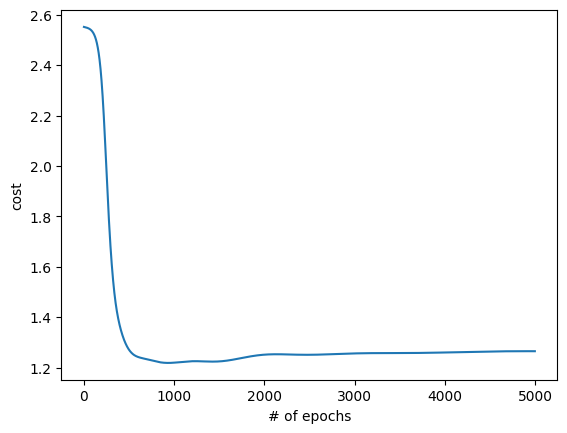

In [27]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, )

## Evaluate

In [28]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

In [30]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

after's neighbor words: ['the', 'investing', 'market', 'deduction']
costs's neighbor words: ['of', 'the', 'beating', 'after']
of's neighbor words: ['investing', 'the', 'deduction', 'costs']
is's neighbor words: ['a', 'market', 'game', 'the']
loser's's neighbor words: ['a', 'game', 'market', 'of']
game's neighbor words: ["loser's", 'is', 'stock', 'beating']
stock's neighbor words: ['market', 'the', 'a', 'beating']
a's neighbor words: ["loser's", 'is', 'stock', 'beating']
deduction's neighbor words: ['of', 'the', 'beating', 'after']
the's neighbor words: ['stock', 'after', 'of', 'beating']
beating's neighbor words: ['the', 'investing', 'market', 'deduction']
market's neighbor words: ['is', 'stock', "loser's", 'beating']
investing's neighbor words: ['beating', 'of', 'the', 'is']
